In [1]:
# this notebook shows how to access the SunPoint solar irradiance map data

# the products are at: https://thredds.met.no/thredds/catalog/sunpoint/ML-Optimized-Maps/catalog.html

# we provide hourly data in 2 different chunckings:
# - 1 chunk = 1 timestep and the full map spatial extent: this is fast to extract a full map at a given timestep, slow to extract a timeseries at a given point; location: https://thredds.met.no/thredds/catalog/sunpoint/ML-Optimized-Maps/hourly/field_access/catalog.html
# - 1 chunk = 1 point on the map and the full timeseries: this is fast to extract a timeseries at one point, slow to extract a full map at a given timeseries; location: https://thredds.met.no/thredds/catalog/sunpoint/ML-Optimized-Maps/hourly/point_access/catalog.html

# we provide monthly average data; location: https://thredds.met.no/thredds/catalog/sunpoint/ML-Optimized-Maps/monthly/catalog.html

# note that if you use these data intensely, it may be a better idea to download the data locally to your machine and directly use the local files, rather than going through the thredds server
# this will be quite a bit faster!
# to do so, just replace the thredds urls by the local paths in the "_base_string" paths in the data loading cells below

# ask for help / provide feedback on the issue tracker system of the supporting repository at: https://github.com/metno/2024_Sunpoint_solar_irradiance_map_over_Norway_1991-2020

# read about the product in the user manual at: https://github.com/metno/2024_Sunpoint_solar_irradiance_map_over_Norway_1991-2020/blob/main/2024_SunPoint_user_instructions_v1.pdf , and the paper at https://arxiv.org/abs/2501.04381

In [2]:
# to download the data locally, so that you do not need to rely on thredds, and you can use fast local drives:

# NOTE: be respectuous of our thredds servers, do NOT start parallel downloads as this may overload the system
# it will take a while to run this cell, be patient / run overnight! :)

# NOTE: if you use local data, remember to change the paths in the
# - ml_maps_chunkmap_base_string
# - ml_maps_chunktimeseries_base_string
# - xr_ml_maps_chunkmap_monthly
# definitions below, so you point to the local files and not to the thredds resource!

# this will take quite a bit of time: interrupt your kernel if you are not interested in downloading the data locally

!wget "https://thredds.met.no/thredds/fileServer/sunpoint/ML-Optimized-Maps/monthly/ml_optimized_downwards_solar_radiation_at_ground_monthly_sum_1991-2020.nc"
!for i in $(seq 1991 2020); do wget "https://thredds.met.no/thredds/fileServer/sunpoint/ML-Optimized-Maps/hourly/point_access/ml_optimized_downwards_solar_radiation_at_ground_${i}_pt.nc"; wget "https://thredds.met.no/thredds/fileServer/sunpoint/ML-Optimized-Maps/hourly/field_access/ml_optimized_downwards_solar_radiation_at_ground_${i}_fld.nc"; done

--2025-01-28 15:10:35--  https://thredds.met.no/thredds/fileServer/sunpoint/ML-Optimized-Maps/monthly/ml_optimized_downwards_solar_radiation_at_ground_monthly_sum_1991-2020.nc
Resolving thredds.met.no (thredds.met.no)... 157.249.120.41, 157.249.121.4
Connecting to thredds.met.no (thredds.met.no)|157.249.120.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 720085450 (687M) [application/x-netcdf]
Saving to: ‘ml_optimized_downwards_solar_radiation_at_ground_monthly_sum_1991-2020.nc.2’

ed_downwards_solar_  26%[====>               ] 182,83M  47,3MB/s    eta 11s    ^C
--2025-01-28 15:10:39--  https://thredds.met.no/thredds/fileServer/sunpoint/ML-Optimized-Maps/hourly/point_access/ml_optimized_downwards_solar_radiation_at_ground_1991_pt.nc
Resolving thredds.met.no (thredds.met.no)... 157.249.121.4, 157.249.120.41
Connecting to thredds.met.no (thredds.met.no)|157.249.121.4|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 1464914973 (1,4G) [appl

In [2]:
# this notebook is python3
# use any recent version of python3 and of the packages needed

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd

In [4]:
#################################################################################################################################################################################
# helper functions

In [5]:
def plot_hourly_map(xr_input, time_to_plot):
    """A simple helper function to plot an hourly map in different ways.
    Args:
        - xr_input: xarray dataset from which to plot
        - time_to_plot: datetime.datetime at which to plot"""

    # ------------------------------------------------------------ 
    # mapping prediction source -> numerical value, higher is "better model"
    columns_priority = ["prediction_nn_full", "prediction_sklearn_full", "SSI_value_cmsaf_sis_sarah", "prediction_nn_nosat", "prediction_sklearn_nosat", "rsds_era5", "rsds_nora3"]
    columns_priority.reverse()
    dict_source_to_numval = {}
    for crrt_priority, crrt_column in enumerate(columns_priority):
        dict_source_to_numval[crrt_column] = crrt_priority
    
    # ------------------------------------------------------------ 
    # figure showing predictions
    #
    fig, ax = plt.subplots(1,1)
    #
    xr_input["GHI"].interp(time=time_to_plot, method="nearest").plot(ax=ax)
    #
    ax.set_facecolor('gray')
    #
    plt.show()
    
    # ------------------------------------------------------------ 
    # figure showing predictions with fixed range
    delta_threshold = 100
    half_delta_thresholds = delta_threshold / 2.0
    list_thresholds = list(range(0, 1100, delta_threshold))
    #
    cmap = plt.get_cmap("RdBu_r", len(list_thresholds))
    #
    fig, ax = plt.subplots(1,1)
    #
    lats = xr_input["lat"].to_numpy()
    lons = xr_input["lon"].to_numpy()
    prediction_map = xr_input["GHI"].interp(time=time_to_plot, method="nearest").to_numpy()
    #
    plt.pcolor(lons, lats, prediction_map, cmap=cmap, vmin=-half_delta_thresholds, vmax=list_thresholds[-1]+half_delta_thresholds)
    #
    cbar = plt.colorbar()
    ticks = list_thresholds
    labels = [str(crrt_threshold) for crrt_threshold in list_thresholds]
    cbar.set_ticks(ticks=ticks, labels=labels)
    cbar.set_label('downwards_solar_radiation_at_ground [W/m**2]')
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"{time_to_plot}")
    #
    plt.show()

    # ------------------------------------------------------------ 
    # figure showing kind of predictions
    #
    cmap = plt.get_cmap('RdBu', len(columns_priority))
    #
    fig, ax = plt.subplots(1,1)
    #
    lats = xr_input["lat"].to_numpy()
    lons = xr_input["lon"].to_numpy()
    prediction_kind = xr_input["model_index"].interp(time=time_to_plot, method="nearest").to_numpy()
    #
    plt.pcolor(lons, lats, prediction_kind, cmap=cmap, vmin=-0.5, vmax=len(columns_priority)-0.5)
    #
    cbar = plt.colorbar()
    labels = dict_source_to_numval.keys()
    ticks = [dict_source_to_numval[key] for key in labels]
    cbar.set_ticks(ticks=ticks, labels=labels)
    cbar.set_label('prediction category')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    ax.set_facecolor('gray')
    #
    plt.title(f"{time_to_plot}")
    #
    plt.show()


def plot_get_timeseries_at_point(xr_input, lat, lon, time_start=datetime.datetime(1991, 1, 1, 0, 0, 0), time_end=datetime.datetime(2020, 12, 31, 23, 59, 59), plot=True, csv_export=True):
    """Get and plot a timeseries of the GHI.
    Args:
        - xr_input: the xarray dataset to use as data source
        - lat, lon: the lat and lon where to extract (will use the nearest point)
        - time_start, time_end: the time range over which to extract
        - plot: True to plot, False to not plot
        - csv_filename: True to export, False to not export, as a csv
    Returns:
        - data: the extracted 1-point pandas timeseries"""

    # this only defines the extraction operation but does not run it (lazy evaluation)
    xr_extraction = xr_input.sel(time=slice(time_start, time_end)).interp(lat=[lat], lon=[lon], method="nearest")
    
    # this actually performs the data retrieval
    data = xr_extraction.to_dataframe()
    
    if csv_export:
        data.to_csv(f"./ghi_timeseries_{lat}N_{lon}E_{time_start}_to_{time_end}.csv")

    if plot:
        fix, ax = plt.subplots(1, 1)
        plt.plot(data.index.get_level_values(0), data["GHI"])
        plt.xticks(rotation=45)
        plt.title(f"GHI [{time_start};{time_end}]")
        plt.ylabel("GHI [W/m**2]")
        plt.show()
        
        fix, ax = plt.subplots(1, 1)
        plt.plot(data.index.get_level_values(0), data["model_index"], "x")
        plt.title(f"model_index [{time_start};{time_end}]")
        plt.xticks(rotation=45)
        plt.yticks([6, 5, 4, 3, 2, 1, 0], ["prediction_nn_full", "prediction_sklearn_full", "SSI_value_cmsaf_sis_sarah", "prediction_nn_nosat", "prediction_sklearn_nosat", "rsds_era5", "rsds_nora3"])
        plt.show()

    return data

In [6]:
#################################################################################################################################################################################
# the following cells show how to extract data from the field_access hourly maps

In [7]:
# prepare hourly data reader

ml_maps_chunkmap_base_string = "https://thredds.met.no/thredds/dodsC/sunpoint/ML-Optimized-Maps/hourly/field_access/ml_optimized_downwards_solar_radiation_at_ground_"

list_of_ml_maps_chunkmap_files = []
for year in range(1991, 2020+1):
    list_of_ml_maps_chunkmap_files.append(f"{ml_maps_chunkmap_base_string}{year:04}_fld.nc")

# if you need to check what files were used in the mfdataset
# print(f"{list_of_ml_maps_files = })

xr_ml_maps_chunkmap_hourly = xr.open_mfdataset(list_of_ml_maps_chunkmap_files)

In [8]:
# observe the _ChunkSizes for the variables; this is optimized for accessing a map at a given point in time
xr_ml_maps_chunkmap_hourly

<xarray.Dataset>
Dimensions:      (time: 262992, lat: 500, lon: 1000)
Coordinates:
  * time         (time) datetime64[ns] 1991-01-01 ... 2020-12-31T23:00:00
  * lat          (lat) float64 57.0 57.03 57.06 57.09 ... 71.91 71.94 71.97 72.0
  * lon          (lon) float64 4.0 4.03 4.06 4.09 ... 33.91 33.94 33.97 34.0
Data variables:
    GHI          (time, lat, lon) float32 dask.array<chunksize=(8760, 500, 1000), meta=np.ndarray>
    model_index  (time, lat, lon) float32 dask.array<chunksize=(8760, 500, 1000), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.9 (ht...
    CDO:                             Climate Data Operators version 1.9.9 (ht...
    Conventions:                     CF-1.10
    DODS_EXTRA.Unlimited_Dimension:  time

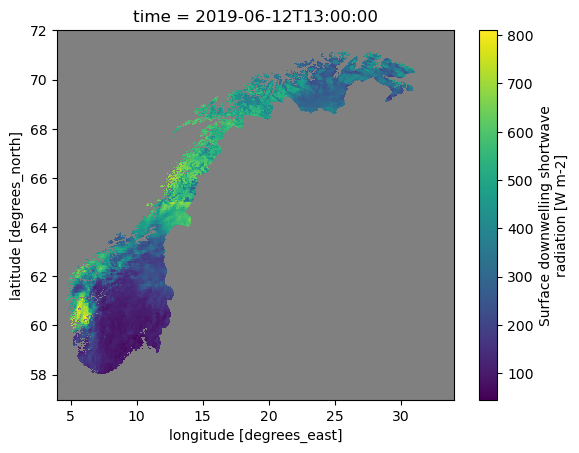

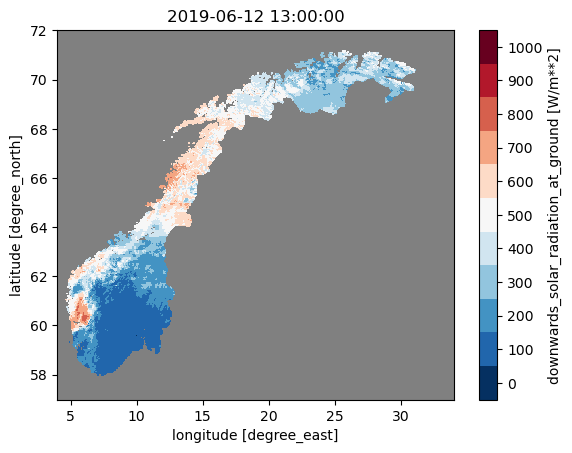

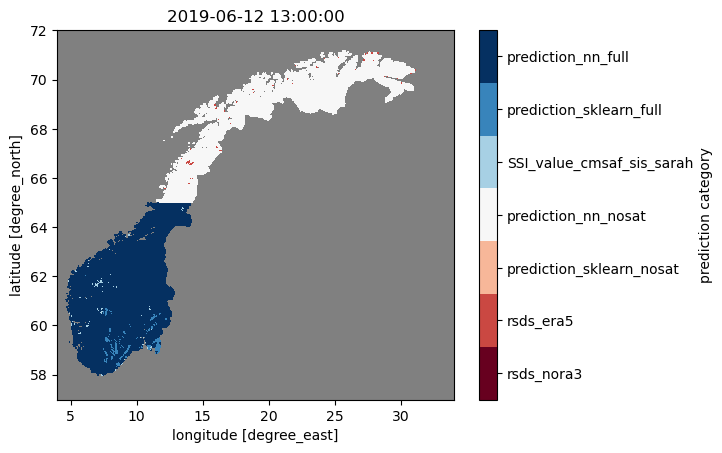


7.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n1 -r1

# the field data are effective for plotting a full map at a single time (see execution time at the end of the output; a significant part of the time used is for plotting)
# this is the right way to extract a map of data
plot_hourly_map(xr_ml_maps_chunkmap_hourly, datetime.datetime(2019, 6, 12, 13))

print("")

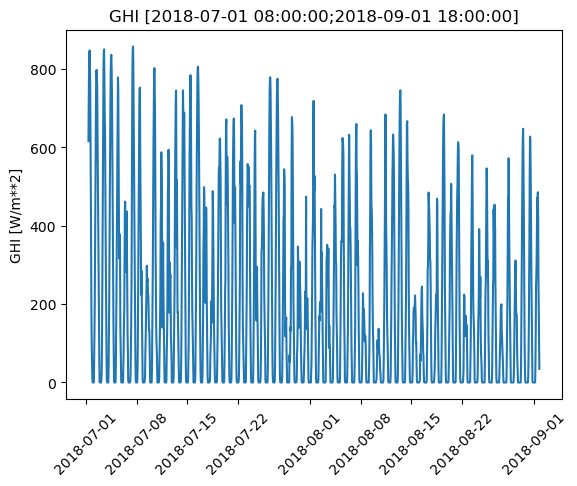

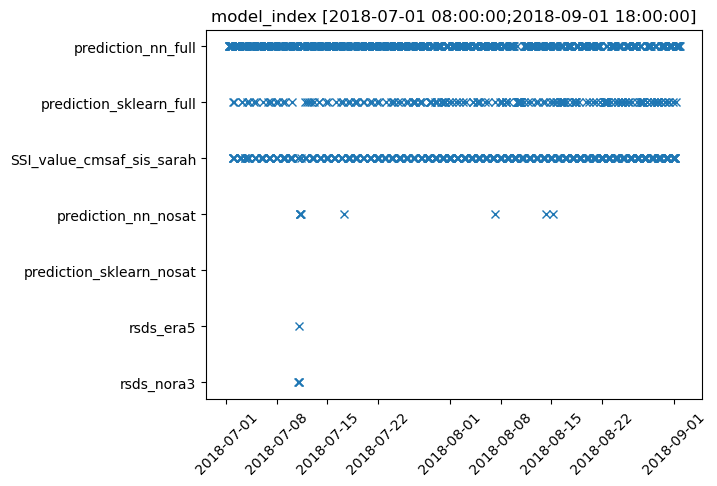


1min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n1 -r1

# the field data are very ineffective for plotting a timeseries at a single location (see execution time at the end of the output; we are only gathering a couple of months!)
# note: after running it once, the thredds server caches data on the server side, so the same request done again within a few minutes to hours will go much faster
# what takes time here is extracting a timeseries from a field-chuncked optimized dataset: do not do this!
timeseries_onelocation = plot_get_timeseries_at_point(xr_ml_maps_chunkmap_hourly, 62.0, 9.0, time_start=datetime.datetime(2018, 7, 1, 8, 0, 0), time_end=datetime.datetime(2018, 9, 1, 18, 0, 0), plot=True, csv_export=True)

print("")

In [11]:
# the %%timeit magics in the previous cell make the timeseries_onelocation variable unaccessible in the next cell; re-do it here to be able to show the outputted variable
timeseries_onelocation = plot_get_timeseries_at_point(xr_ml_maps_chunkmap_hourly, 62.0, 9.0, time_start=datetime.datetime(2018, 7, 1, 8, 0, 0), time_end=datetime.datetime(2018, 9, 1, 18, 0, 0), plot=False, csv_export=False)
timeseries_onelocation

,,,GHI,model_index
time,lat,lon,,
2018-07-01 08:00:00,62.0,9.0,616.210327,6.0
2018-07-01 09:00:00,62.0,9.0,722.083496,6.0
2018-07-01 10:00:00,62.0,9.0,802.886414,6.0
2018-07-01 11:00:00,62.0,9.0,842.555786,6.0
2018-07-01 12:00:00,62.0,9.0,847.503662,6.0
...,...,...,...,...
2018-09-01 14:00:00,62.0,9.0,427.235901,6.0
2018-09-01 15:00:00,62.0,9.0,266.823608,6.0
2018-09-01 16:00:00,62.0,9.0,186.421234,6.0


In [12]:
#################################################################################################################################################################################
# the following cells show how to extract data from the point_access hourly maps

In [13]:
# prepare hourly data reader

ml_maps_chunktimeseries_base_string = "https://thredds.met.no/thredds/dodsC/sunpoint/ML-Optimized-Maps/hourly/point_access/ml_optimized_downwards_solar_radiation_at_ground_"

list_of_ml_maps_chunktimeseries_files = []
for year in range(1991, 2020+1):
    list_of_ml_maps_chunktimeseries_files.append(f"{ml_maps_chunktimeseries_base_string}{year:04}_pt.nc")

# if you need to check what files were used in the mfdataset
# print(f"{list_of_ml_maps_files = })

xr_ml_maps_chunktimeseries_hourly = xr.open_mfdataset(list_of_ml_maps_chunktimeseries_files)

In [14]:
# observe the _ChunkSizes for the variables; this is optimized for accessing a timeseries at a given point in space
xr_ml_maps_chunktimeseries_hourly

<xarray.Dataset>
Dimensions:      (time: 262992, lat: 500, lon: 1000)
Coordinates:
  * time         (time) datetime64[ns] 1991-01-01 ... 2020-12-31T23:00:00
  * lat          (lat) float64 57.0 57.03 57.06 57.09 ... 71.91 71.94 71.97 72.0
  * lon          (lon) float64 4.0 4.03 4.06 4.09 ... 33.91 33.94 33.97 34.0
Data variables:
    GHI          (time, lat, lon) float32 dask.array<chunksize=(8760, 500, 1000), meta=np.ndarray>
    model_index  (time, lat, lon) float32 dask.array<chunksize=(8760, 500, 1000), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.9 (ht...
    CDO:                             Climate Data Operators version 1.9.9 (ht...
    Conventions:                     CF-1.10
    DODS_EXTRA.Unlimited_Dimension:  time

In [15]:
# this is so slow that we do not get this done in reasonable time; actually drop it; this may take many hours or even days to run!
# 
# %%timeit -n1 -r1
# 
# # the point data are very ineffective for plotting a full map at a single time (see execution time at the end of the output)
# # this is NOT the right way to extract a map of data; do not do that!
# plot_hourly_map(xr_ml_maps_chunktimeseries_hourly, datetime.datetime(2019, 6, 12, 13))
# 
# print("")

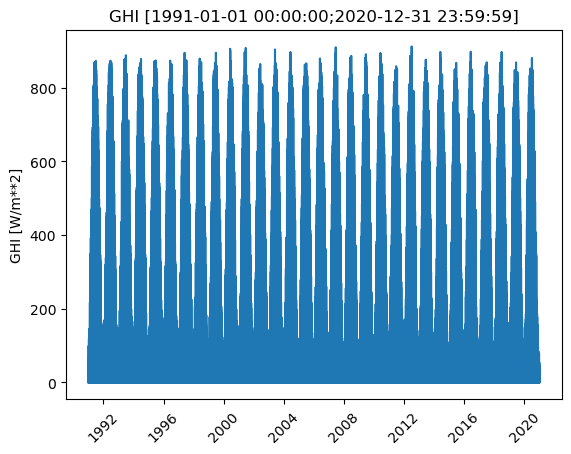

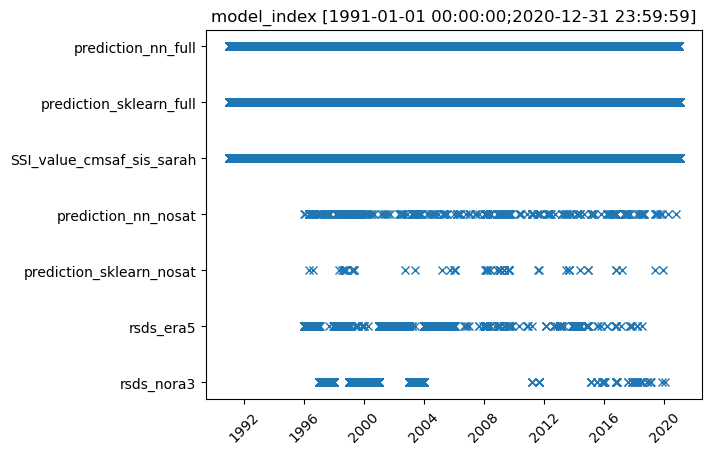


37.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
%%timeit -n1 -r1

# the point data are effective for plotting a full timeseries at a single point in space (see execution time at the end of the output)
# this is the right way to extract a time series
timeseries_onelocation = plot_get_timeseries_at_point(xr_ml_maps_chunktimeseries_hourly, 62.0, 9.0, time_start=datetime.datetime(1991, 1, 1, 0, 0, 0), time_end=datetime.datetime(2020, 12, 31, 23, 59, 59), plot=True, csv_export=True)

print("")

In [17]:
# the %%timeit magics in the previous cell make the timeseries_onelocation variable unaccessible in the next cell; re-do it here to be able to show the outputted variable
timeseries_onelocation = plot_get_timeseries_at_point(xr_ml_maps_chunktimeseries_hourly, 62.0, 9.0, time_start=datetime.datetime(1991, 1, 1, 0, 0, 0), time_end=datetime.datetime(2020, 12, 31, 23, 59, 59), plot=False, csv_export=False)
timeseries_onelocation

,,,GHI,model_index
time,lat,lon,,
1991-01-01 00:00:00,62.0,9.0,0.0,4.0
1991-01-01 01:00:00,62.0,9.0,0.0,4.0
1991-01-01 02:00:00,62.0,9.0,0.0,4.0
1991-01-01 03:00:00,62.0,9.0,0.0,4.0
1991-01-01 04:00:00,62.0,9.0,0.0,4.0
...,...,...,...,...
2020-12-31 19:00:00,62.0,9.0,0.0,4.0
2020-12-31 20:00:00,62.0,9.0,0.0,4.0
2020-12-31 21:00:00,62.0,9.0,0.0,4.0


In [18]:
#################################################################################################################################################################################
# the following cells are for extracting data from the monthly sum, do cumulated sums over a year, yearly averages, etc

In [19]:
def plot_monthly_map(xr_input, year, month):
    time_to_plot = datetime.datetime(year, month, 15)
    
    # # ------------------------------------------------------------ 
    # # figure showing predictions
    # # this messes up the labels, drop and do by hand under instead
    # xr_input["GHI_acc"].interp(time=time_to_plot, method="nearest").plot()
    # plt.title(f"{time_to_plot.strftime('%Y-%m')}")
    # #
    # plt.show()

    prediction_map = xr_input["GHI_acc"].interp(time=time_to_plot, method="nearest").to_numpy()
    #
    lats = xr_input["lat"].to_numpy()
    lons = xr_input["lon"].to_numpy()
    
    # ------------------------------------------------------------ 
    # figure showing predictions
    fig, ax = plt.subplots(1, 1)
    #
    plt.pcolor(lons, lats, prediction_map)
    #
    cbar = plt.colorbar()
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"{time_to_plot.strftime('%Y-%m')}")
    #
    plt.show()
    
    # ------------------------------------------------------------ 
    # figure showing predictions with fixed range, and a different unit
    fig, ax = plt.subplots(1, 1)
    #
    delta_threshold = 30
    half_delta_thresholds = delta_threshold / 2.0
    list_thresholds = list(range(0, 230, delta_threshold))
    #
    cmap = plt.get_cmap("RdBu_r", len(list_thresholds))
    #
    plt.pcolor(lons, lats, prediction_map, cmap=cmap, vmin=-half_delta_thresholds, vmax=list_thresholds[-1]+half_delta_thresholds)
    #
    cbar = plt.colorbar()
    ticks = list_thresholds
    labels = [str(crrt_threshold) for crrt_threshold in list_thresholds]
    cbar.set_ticks(ticks=ticks, labels=labels)
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"{time_to_plot.strftime('%Y-%m')}")
    #
    plt.show()


def plot_yearly_map(xr_input, year):
    yearly_sum = xr_input.sel(time=slice(f"{year}", f"{year}")).sum(dim="time", skipna=False)
    
    # # ------------------------------------------------------------ 
    # # figure showing predictions
    # yearly_sum["GHI_acc"].plot()
    # plt.title(f"yearly sum {year}")
    # #
    # plt.show()

    #
    lats = xr_input["lat"].to_numpy()
    lons = xr_input["lon"].to_numpy()
    prediction_map = yearly_sum["GHI_acc"].to_numpy()

    # ------------------------------------------------------------ 
    # figure showing predictions
    fig, ax = plt.subplots(1, 1)
    #
    plt.pcolor(lons, lats, prediction_map)
    #
    cbar = plt.colorbar()
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"yearly sum {year}")
    #
    plt.show()
    
    # ------------------------------------------------------------ 
    # figure showing predictions with fixed range, and a different unit
    fig, ax = plt.subplots(1, 1)
    #
    delta_threshold = 100
    
    half_delta_thresholds = delta_threshold / 2.0
    list_thresholds = list(range(500, 1250, delta_threshold))
    #
    cmap = plt.get_cmap("RdBu_r", len(list_thresholds))
    #
    plt.pcolor(lons, lats, prediction_map, cmap=cmap, vmin=list_thresholds[0]-half_delta_thresholds, vmax=list_thresholds[-1]+half_delta_thresholds)
    #
    cbar = plt.colorbar()
    ticks = list_thresholds
    labels = [str(crrt_threshold) for crrt_threshold in list_thresholds]
    cbar.set_ticks(ticks=ticks, labels=labels)
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"yearly sum {year}")
    #
    plt.show()


def plot_yearlyaverage_map(xr_input, year_min, year_max):
    yearly_sum = xr_input.sel(time=slice(f"{year_min}", f"{year_max}")).sum(dim="time", skipna=False) / (year_max - year_min + 1)
    
    # # ------------------------------------------------------------ 
    # # figure showing predictions
    # yearly_sum["GHI_acc"].plot()
    # plt.title(f"yearly sum average over [{year_min};{year_max}]")
    # #
    # plt.show()

    lats = xr_input["lat"].to_numpy()
    lons = xr_input["lon"].to_numpy()
    prediction_map = yearly_sum["GHI_acc"].to_numpy()

    # ------------------------------------------------------------ 
    # figure showing predictions
    fig, ax = plt.subplots(1, 1)
    #
    plt.pcolor(lons, lats, prediction_map)
    #
    cbar = plt.colorbar()
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"yearly sum average over [{year_min};{year_max}]")
    #
    plt.show()
    
    # ------------------------------------------------------------ 
    # figure showing predictions with fixed range, and a different unit
    fig, ax = plt.subplots(1, 1)
    #
    delta_threshold = 100
    
    half_delta_thresholds = delta_threshold / 2.0
    list_thresholds = list(range(500, 1250, delta_threshold))
    #
    cmap = plt.get_cmap("RdBu_r", len(list_thresholds))
    #
    plt.pcolor(lons, lats, prediction_map, cmap=cmap, vmin=list_thresholds[0]-half_delta_thresholds, vmax=list_thresholds[-1]+half_delta_thresholds)
    #
    cbar = plt.colorbar()
    ticks = list_thresholds
    labels = [str(crrt_threshold) for crrt_threshold in list_thresholds]
    cbar.set_ticks(ticks=ticks, labels=labels)
    cbar.set_label(f"Accumulated surface downwelling\n shortwave radiation [kWh/m**2]")
    #
    ax.set_facecolor('gray')
    #
    plt.xlabel("longitude [degree_east]")
    plt.ylabel("latitude [degree_north]")
    #
    plt.title(f"yearly sum average over [{year_min};{year_max}]")
    #
    plt.show()

In [20]:
# prepare mean monthly data reader

# html page of the product: https://thredds.met.no/thredds/catalog/sunpoint/ML-Optimized-Maps/monthly/catalog.html
xr_ml_maps_chunkmap_monthly = xr.open_dataset("https://thredds.met.no/thredds/dodsC/sunpoint/ML-Optimized-Maps/monthly/ml_optimized_downwards_solar_radiation_at_ground_monthly_sum_1991-2020.nc")

In [21]:
xr_ml_maps_chunkmap_monthly

<xarray.Dataset>
Dimensions:    (time: 360, bnds: 2, lon: 1000, lat: 500)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-15T12:00:00 ... 2020-12-15T12:00:00
  * lon        (lon) float64 4.0 4.03 4.06 4.09 4.12 ... 33.91 33.94 33.97 34.0
  * lat        (lat) float64 57.0 57.03 57.06 57.09 ... 71.91 71.94 71.97 72.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    GHI_acc    (time, lat, lon) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 2.0.5 (ht...
    CDO:                             Climate Data Operators version 2.0.5 (ht...
    Conventions:                     CF-1.10
    DODS_EXTRA.Unlimited_Dimension:  time

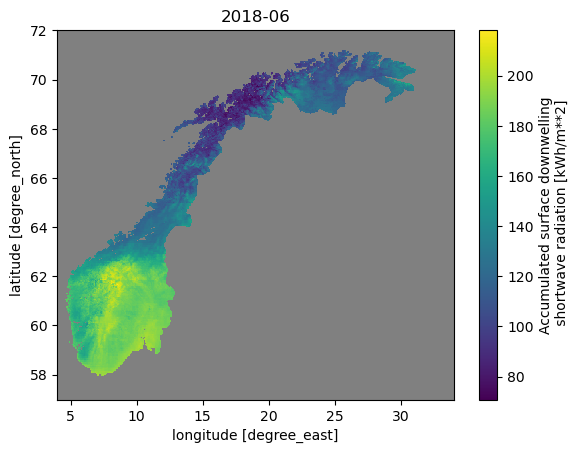

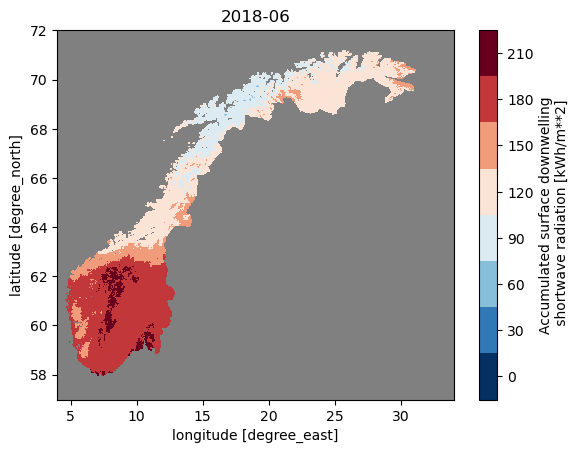

In [22]:
# this is very fast: just read one field
plot_monthly_map(xr_ml_maps_chunkmap_monthly, 2018, 6)

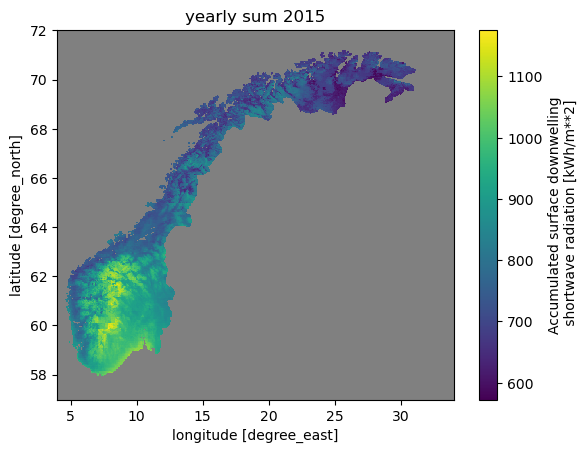

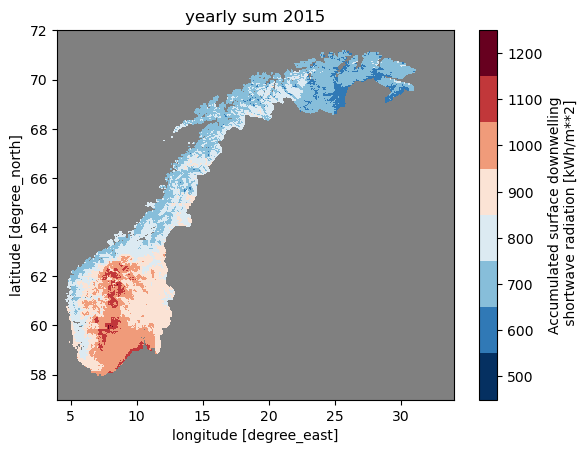

In [23]:
# this takes a bit more time: need to average
plot_yearly_map(xr_ml_maps_chunkmap_monthly, 2015)

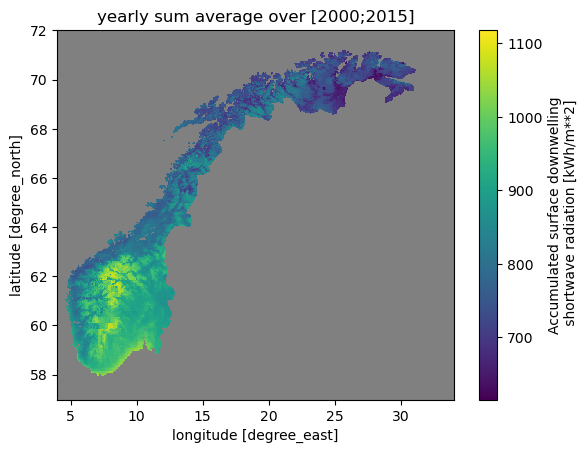

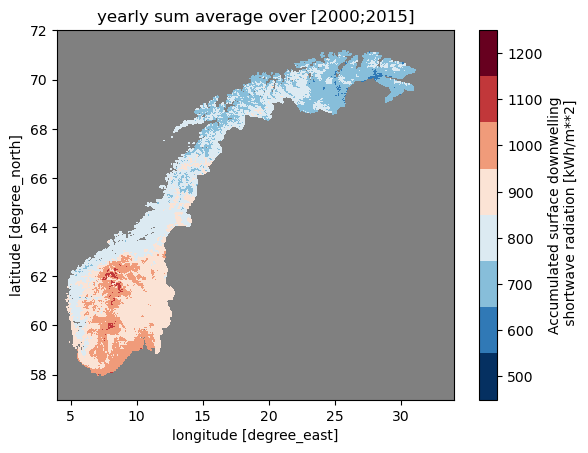

In [24]:
# this takes even a bit more time: need to average over more fields; but this is still quite ok!
plot_yearlyaverage_map(xr_ml_maps_chunkmap_monthly, 2000, 2015)